# CSYE 7245: Big-Data Systems & Intelligence Analytics
> ### Project - News Classification and Sentiment Analysis
>> Around the globe, there are more than 6500 ‘daily’ newspapers, selling close to 400 million copies
every day. Additionally, there are blogs, micro blogs, periodicals, magazines, fanzines etc. How
can we make sense of all this information? How can we classify it and aggregate it so that we can
perform quantitative analysis? This project explores one possible answer to these questions:
classification of news articles by sentiment and topic.
Our vision is to create the capability to track how sentiment on a topic has evolved over time, how
different news outlets cover the same topic and, in the limit, to be able to predict future behavior
through sentiment trends.

<img src="natural-language-tag-cloud.png">

* [1: Stemming and Lemmetization](#chapter-1)
* [2: Count Vs Publications](#chapter-2)
* [3: Count vs Authors](#chapter-3)
* [4: Count Vs Category](#chapter-4)
* [5: Frequency of Words in Title Column](#chapter-5)
* [6: Wordcloud for Title Column](#chapter-6)
* [7: Categorization of the Title Column](#chapter-7)
* [8: Frequency of words in Content Column](#chapter-8)
* [9: Wordcloud for Content Column](#chapter-9)
* [10: Categorization of the Content Column](#chapter-10)
* [11: Vectorization](#chapter-11)
* [12: Prediction of News Title](#chapter-12)
* [13: Validation of the model for title column](#chapter-13)
* [14: Prediction of News Category](#chapter-14)
* [15: Validation of the model for News category](#chapter-15)
* [16: Pickle](#chapter-16)
* [17: License](#chapter-17)
* [18: References](#chapter-18)


In [1]:
#importing important libraries for the project

#!pip install stop_words
#!pip install wordcloud
#!pip install palettable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from PIL import Image
import pickle

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [2]:
df=pd.read_csv('Scrapped_content.csv',error_bad_lines=False)

C:\Users\Ankur\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
columns=['TITLE','PUBLISHER','Content','Author','Category']
df=df[columns]

In [4]:
df=df.dropna(axis=0)
df=df.reset_index()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6243 entries, 0 to 6242
Data columns (total 6 columns):
index        6243 non-null int64
TITLE        6243 non-null object
PUBLISHER    6243 non-null object
Content      6243 non-null object
Author       6243 non-null object
Category     6243 non-null object
dtypes: int64(1), object(5)
memory usage: 292.7+ KB


In [6]:
df=df.drop(['index'],axis=1)

In [7]:
df.head()

TITLE       PUBLISHER  \
0  Fed's Charles Plosser sees high bar for change...        Livemint   
1  ECB FOCUS-Stronger euro drowns out ECB's messa...         Reuters   
2  Forex Market: EUR/USD retreats from 2-1/2-year...  Binary Tribune   
3   ECB's Noyer: Low inflation may hamper adjustment     MarketWatch   
4  ECB Unlocks Door for Further Euro Strength - W...         DailyFX   

                                             Content                   Author  \
0  Paris/London/Atlanta: Federal Reserve Bank of ...            ['Mark Deen']   
1  FRANKFURT, March 10 (Reuters) - The European C...    ['Reuters Editorial']   
2  The euro retreated from highs unseen since Oct...       ['Vladimir Manev']   
3  PARIS--The slow pace of price increases and no...   ['Gabriele Parussini']   
4  Fundamental Forecast for Euro: Neutral\r\n\r\n...  ['Christopher Vecchio']   

   Category  
0  Business  
1  Business  
2  Business  
3  Business  
4  Business

### Stemming and Lemmetization of Title and Content column <a id="chapter-1"></a>
> Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word. And, Lemmatization in linguistics is the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word's lemma, or dictionary form


In [8]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
ps = PorterStemmer()


def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['Title_lemmatized'] = df.TITLE.apply(lemmatize_text)
df['Content_lemmatized'] = df.Content.apply(lemmatize_text)

lemmatization_title=df['Title_lemmatized']
lemmatization_content=df['Content_lemmatized']

def title_stemming(text):
    l = []
    for i in text:
        for j in i:
            #converts list item to lower case
            p=j.lower()
            # removes punctuation,numbers and returns list of words
            q=re.sub('[^A-Za-z]+', ' ', p)
            l.append(ps.stem(q))
    return l

### Count Vs Publications<a id="chapter-2"></a>

Text(0.5,1,'Counts Vs PUBLISHER')

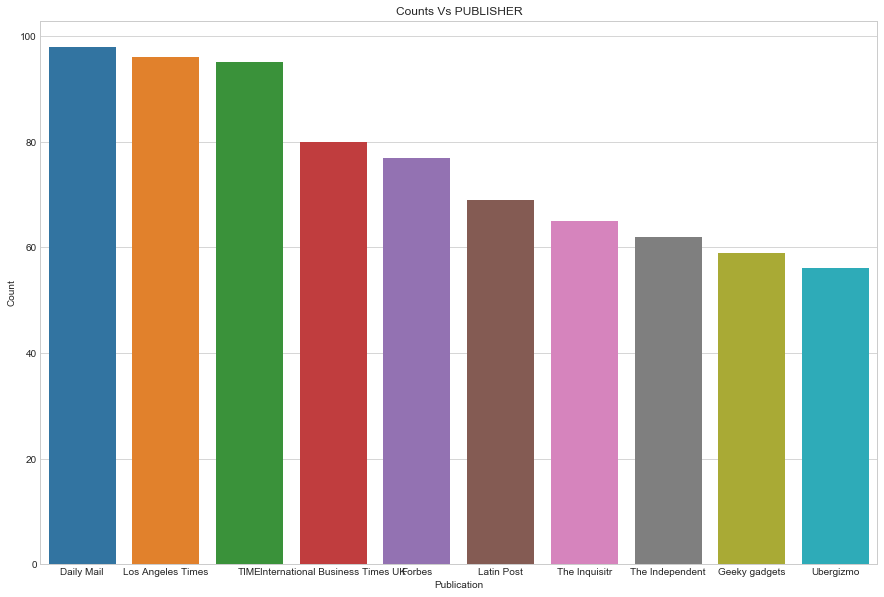

In [9]:
z=df.groupby(by=['PUBLISHER'],as_index=False).count().sort_values(by='TITLE',ascending=False).head(10)

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['PUBLISHER'],y=z['TITLE'], data=z)
plt.xlabel("Publication")
plt.ylabel("Count")
plt.title("Counts Vs PUBLISHER")

The above barplot shows the top 10 publications in the news dataset. The Daily Mail is having highest no. of publications

### Count Vs No. of Authors¶<a id="chapter-3"></a>

Text(0.5,1,'Counts Vs Author')

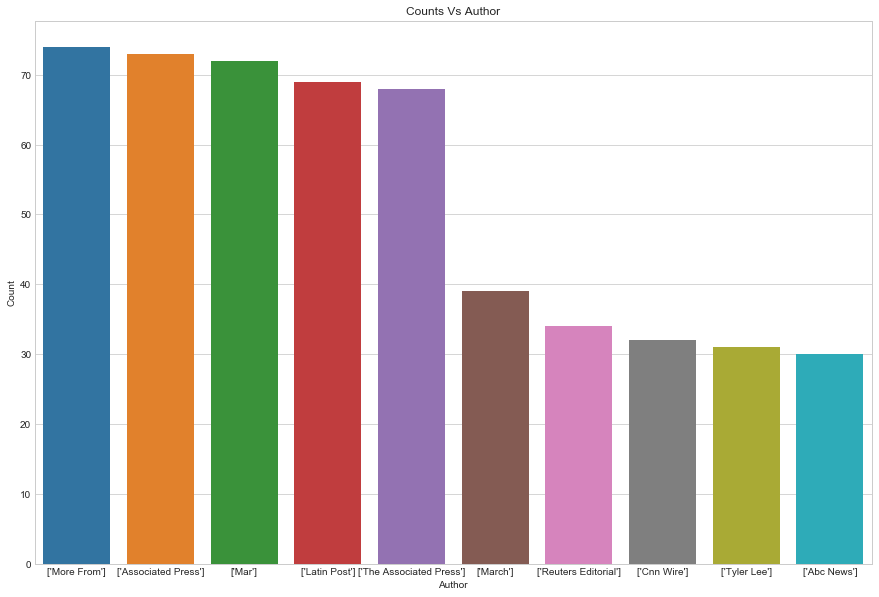

In [10]:
z=df.groupby(by=['Author'],as_index=False).count().sort_values(by='PUBLISHER',ascending=False).head(10)

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['Author'],y=z['PUBLISHER'], data=z)
plt.xlabel("Author")
plt.ylabel("Count")
plt.title("Counts Vs Author")

The above barplot shows the number of publications posted by an author.

### Count Vs Category¶<a id="chapter-4"></a>

Text(0.5,1,'Counts Vs Category')

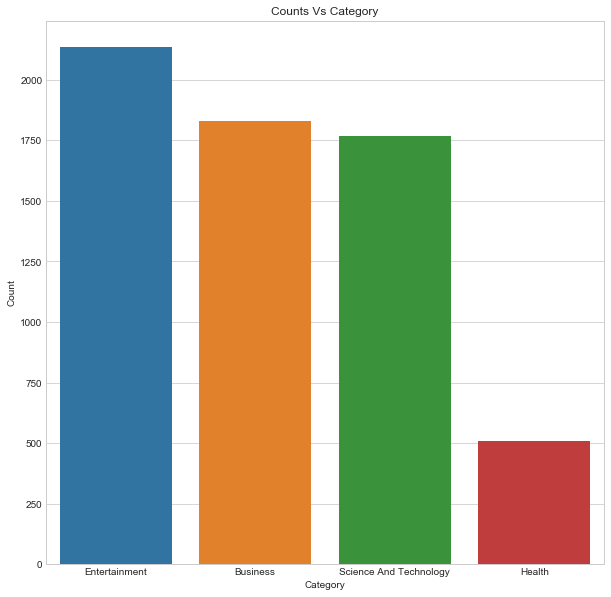

In [11]:
z=df.groupby(by=['Category'],as_index=False).count().sort_values(by='TITLE',ascending=False).head(10)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['Category'],y=z['TITLE'], data=z)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Counts Vs Category")

The above barplot shows that this dataset has more news in Entertainment category.

### Count the frequency of each word and display the words which are occuring most in Title column.<a id="chapter-5"></a>

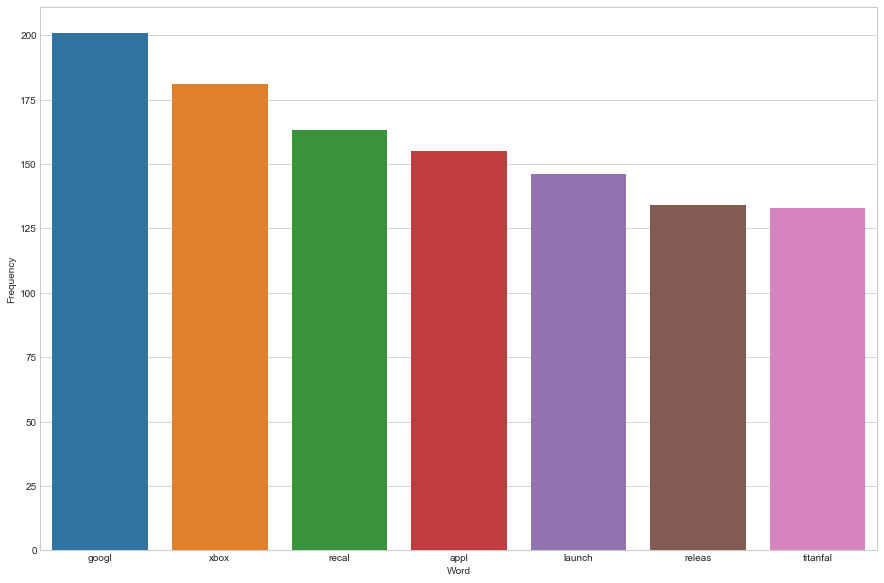

In [12]:
top_N = 100

a=title_stemming(lemmatization_title)

#remove all the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

words_to_remove=['thi','also','it ','us ','one',' ','. ','said','say','new','like','get','make','last','use','said ','new ','get ','say ','xbox ']
filtered_sentence = []
for w in a:
    if w not in (stop_words):
        if w not in (words_to_remove):
            filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

The above boxplot shows the most occuring words in the news headlines.

### The below code will show the wordcloud for the Title column.<a id="chapter-6"></a>

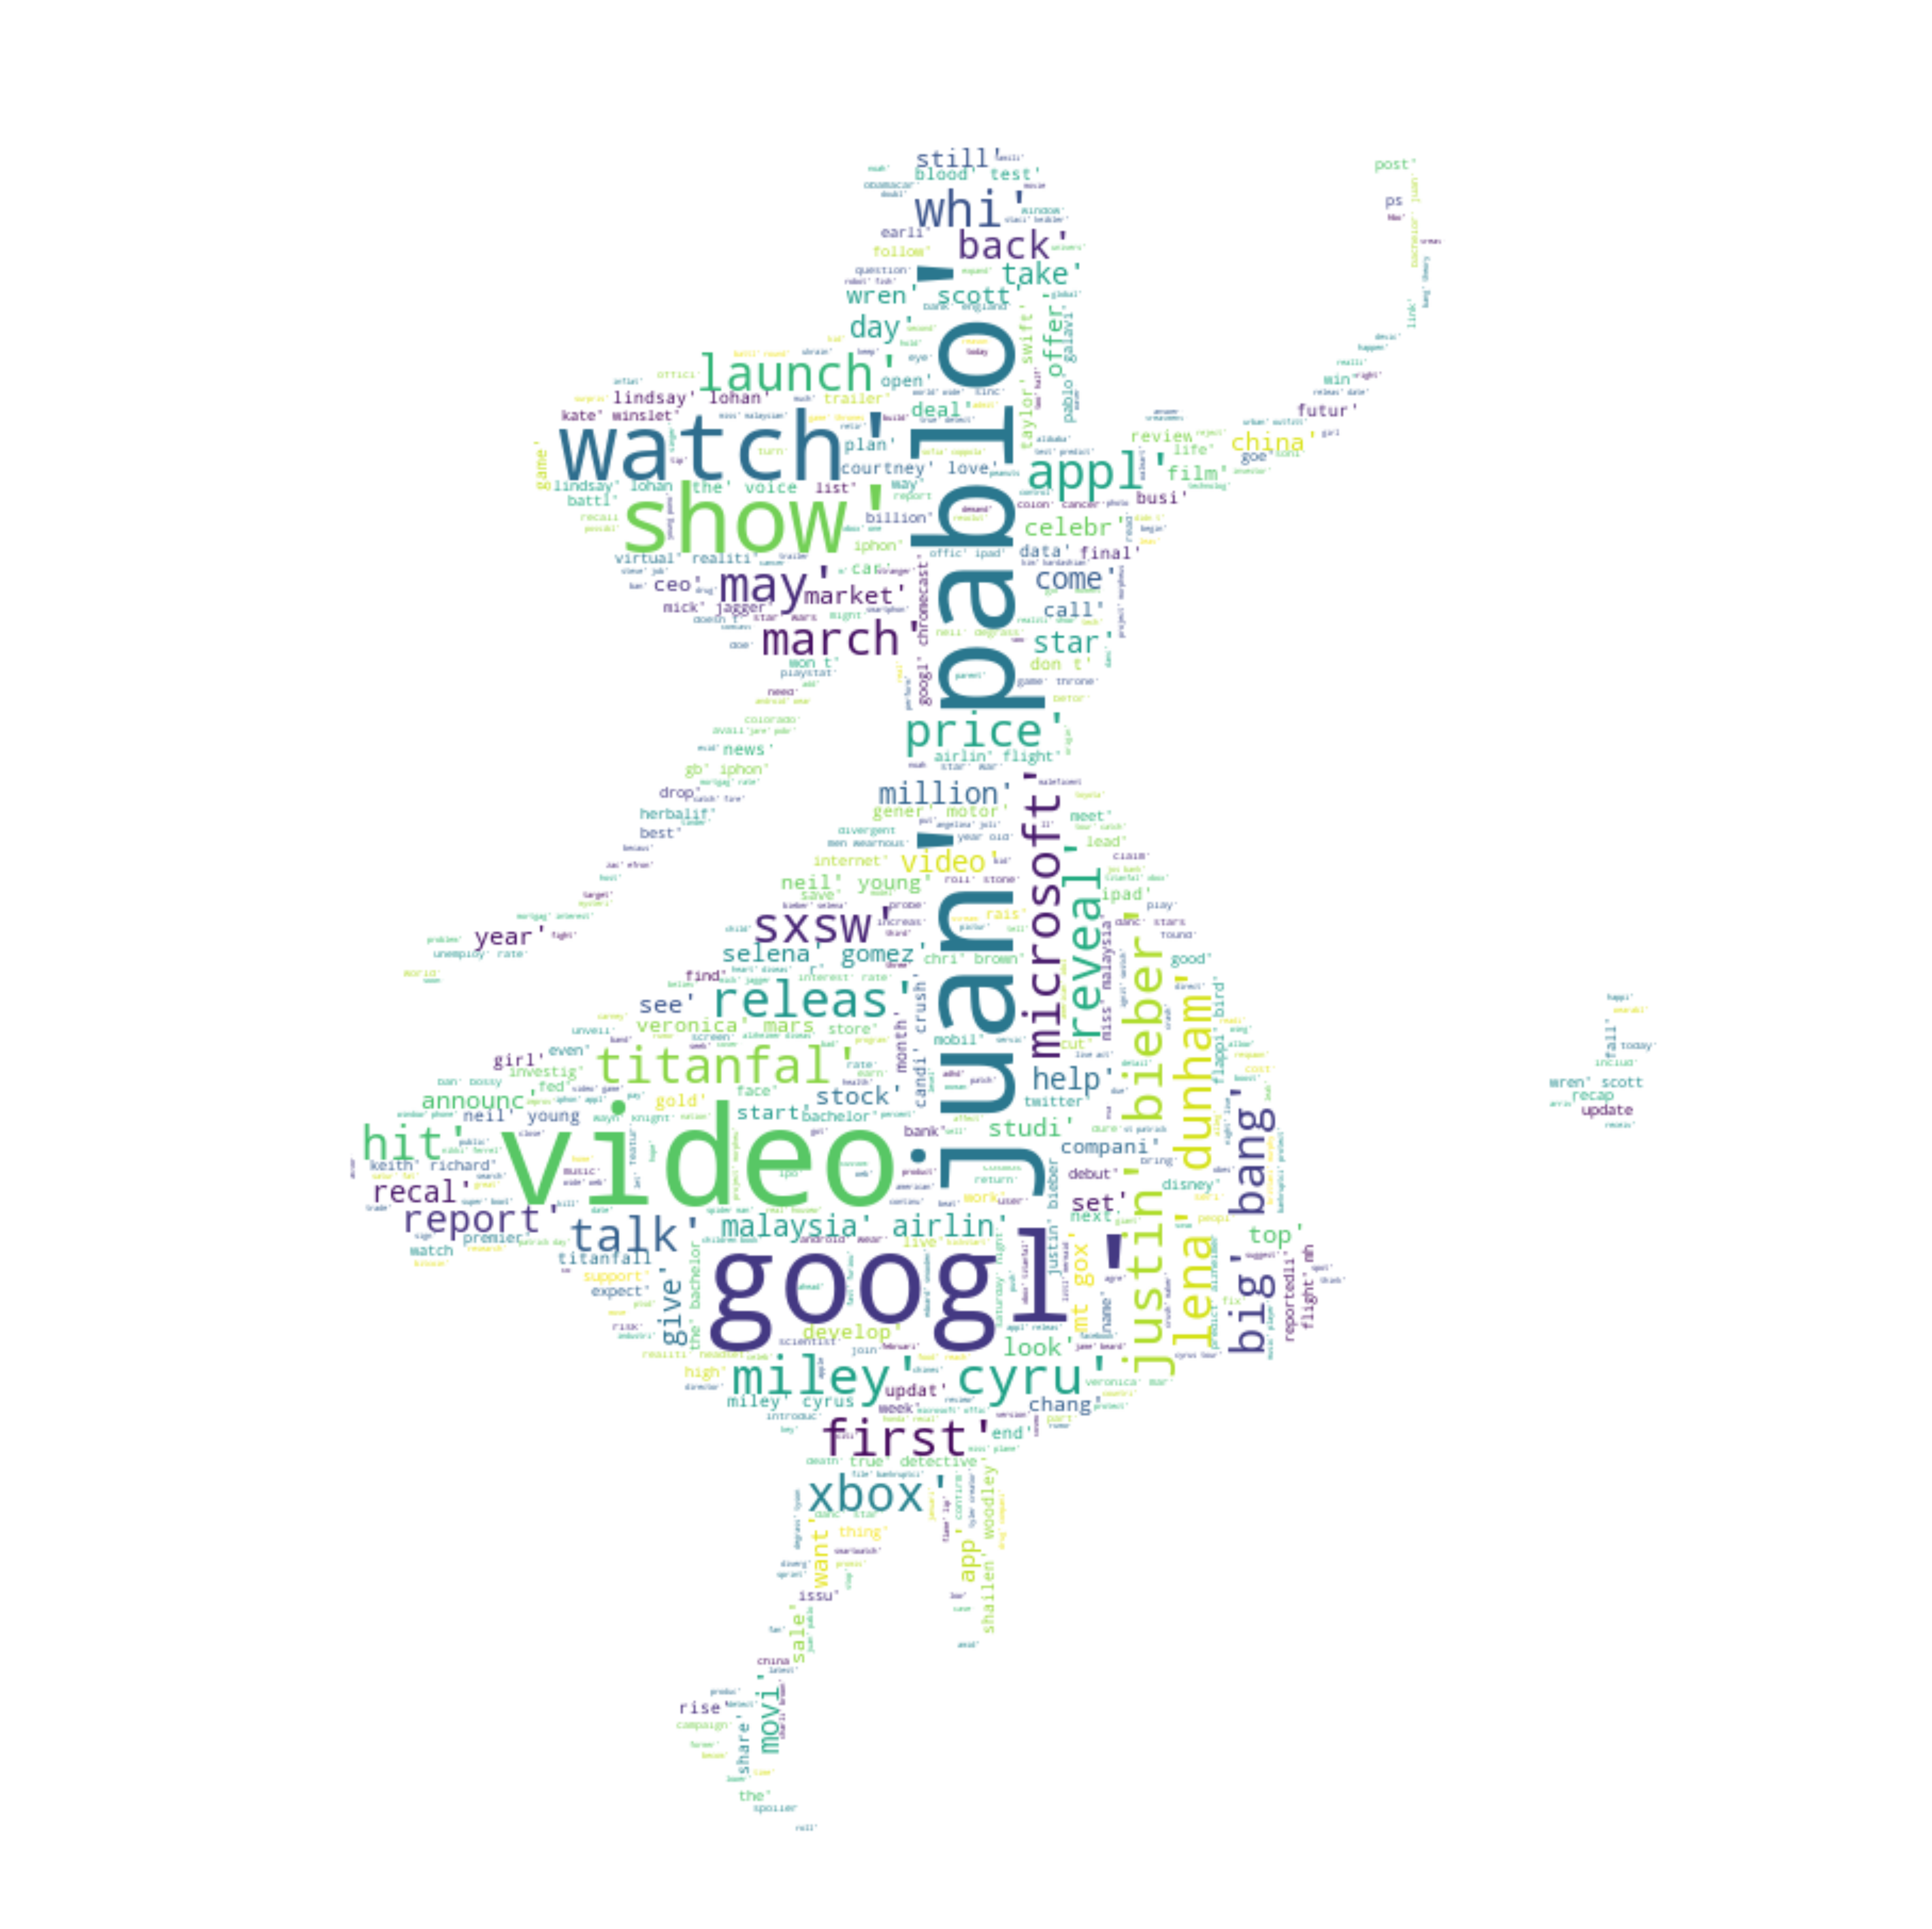

In [13]:
alice_mask = np.array(Image.open("alice_mask.png"))

wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask)

# generate word cloud
wc.generate(str(cleaned_data_title))

# store to file
wc.to_file("wordcloud_title.png")

# show
plt.figure( figsize=(180,80))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()

### Categorize the Title column into positive, negative, and neutral headlines.<a id="chapter-7"></a>

In [14]:
#!pip install textblob

bloblist_desc = list()

df_review_str=df['TITLE'].astype(str)
for row in df_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['TITLE','sentiment','polarity'])

def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0:
        val = "Positive Title"
    elif df_polarity_desc['sentiment'] == 0:
        val = "Neutral Title"
    else:
        val = "Negative Title"
    return val

In [15]:
df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(f, axis=1)
df_polarity_desc.head()

TITLE  sentiment  polarity  \
0  Fed's Charles Plosser sees high bar for change...       0.16      0.54   
1  ECB FOCUS-Stronger euro drowns out ECB's messa...       0.00      0.30   
2  Forex Market: EUR/USD retreats from 2-1/2-year...       0.00      0.00   
3   ECB's Noyer: Low inflation may hamper adjustment       0.00      0.30   
4  ECB Unlocks Door for Further Euro Strength - W...       0.00      0.50   

   Sentiment_Type  
0  Positive Title  
1   Neutral Title  
2   Neutral Title  
3   Neutral Title  
4   Neutral Title

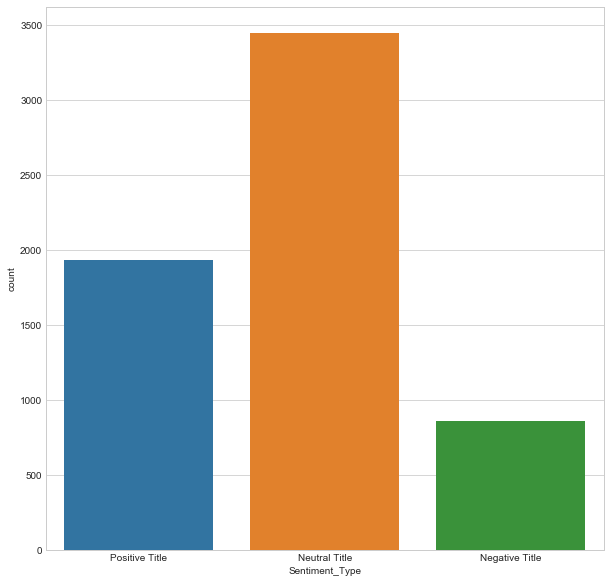

In [16]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

The above barplot shows that there are more Neutral Title in the dataset. 

### Count the frequency of each word and display the words which are occuring most in Content column.<a id="chapter-8"></a>

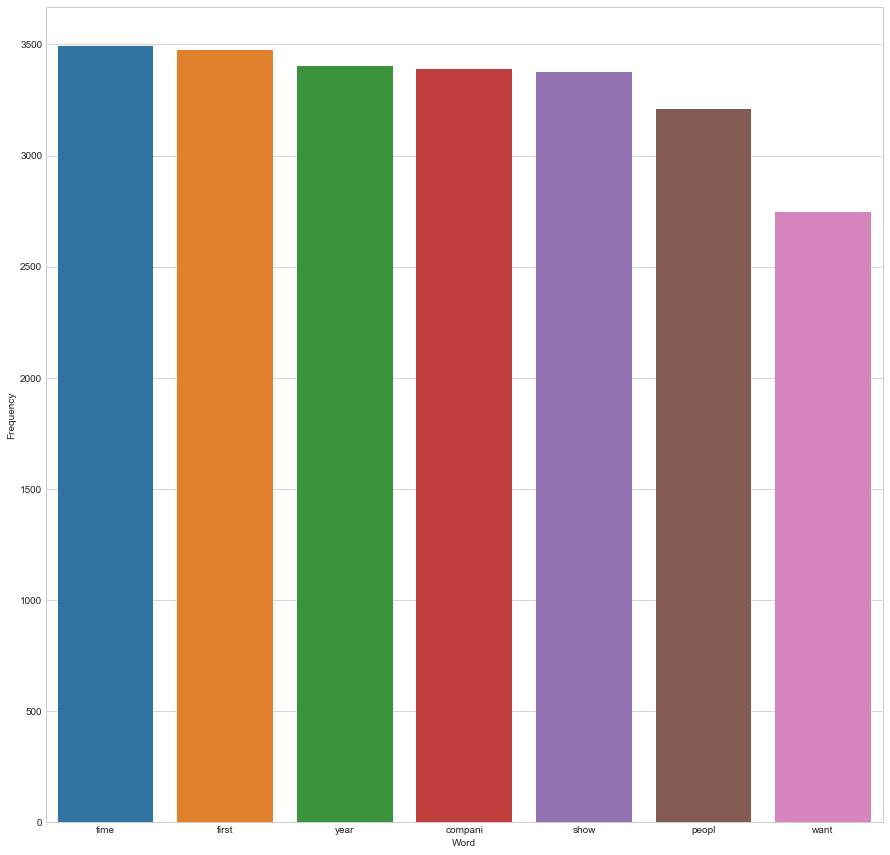

In [17]:
a = title_stemming(lemmatization_content)
words_to_remove=['thi','also','it ','us ','one',' ','. ','said','say','new','like','get','make','last','use','said ']
filtered_sentence = []
for w in a:
    if w not in (stop_words):
        if w not in (words_to_remove):
            filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(15,15))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

The above boxplot shows the most occuring words in the news content.

### The below code will show the wordcloud for the Content column.<a id="chapter-9"></a>

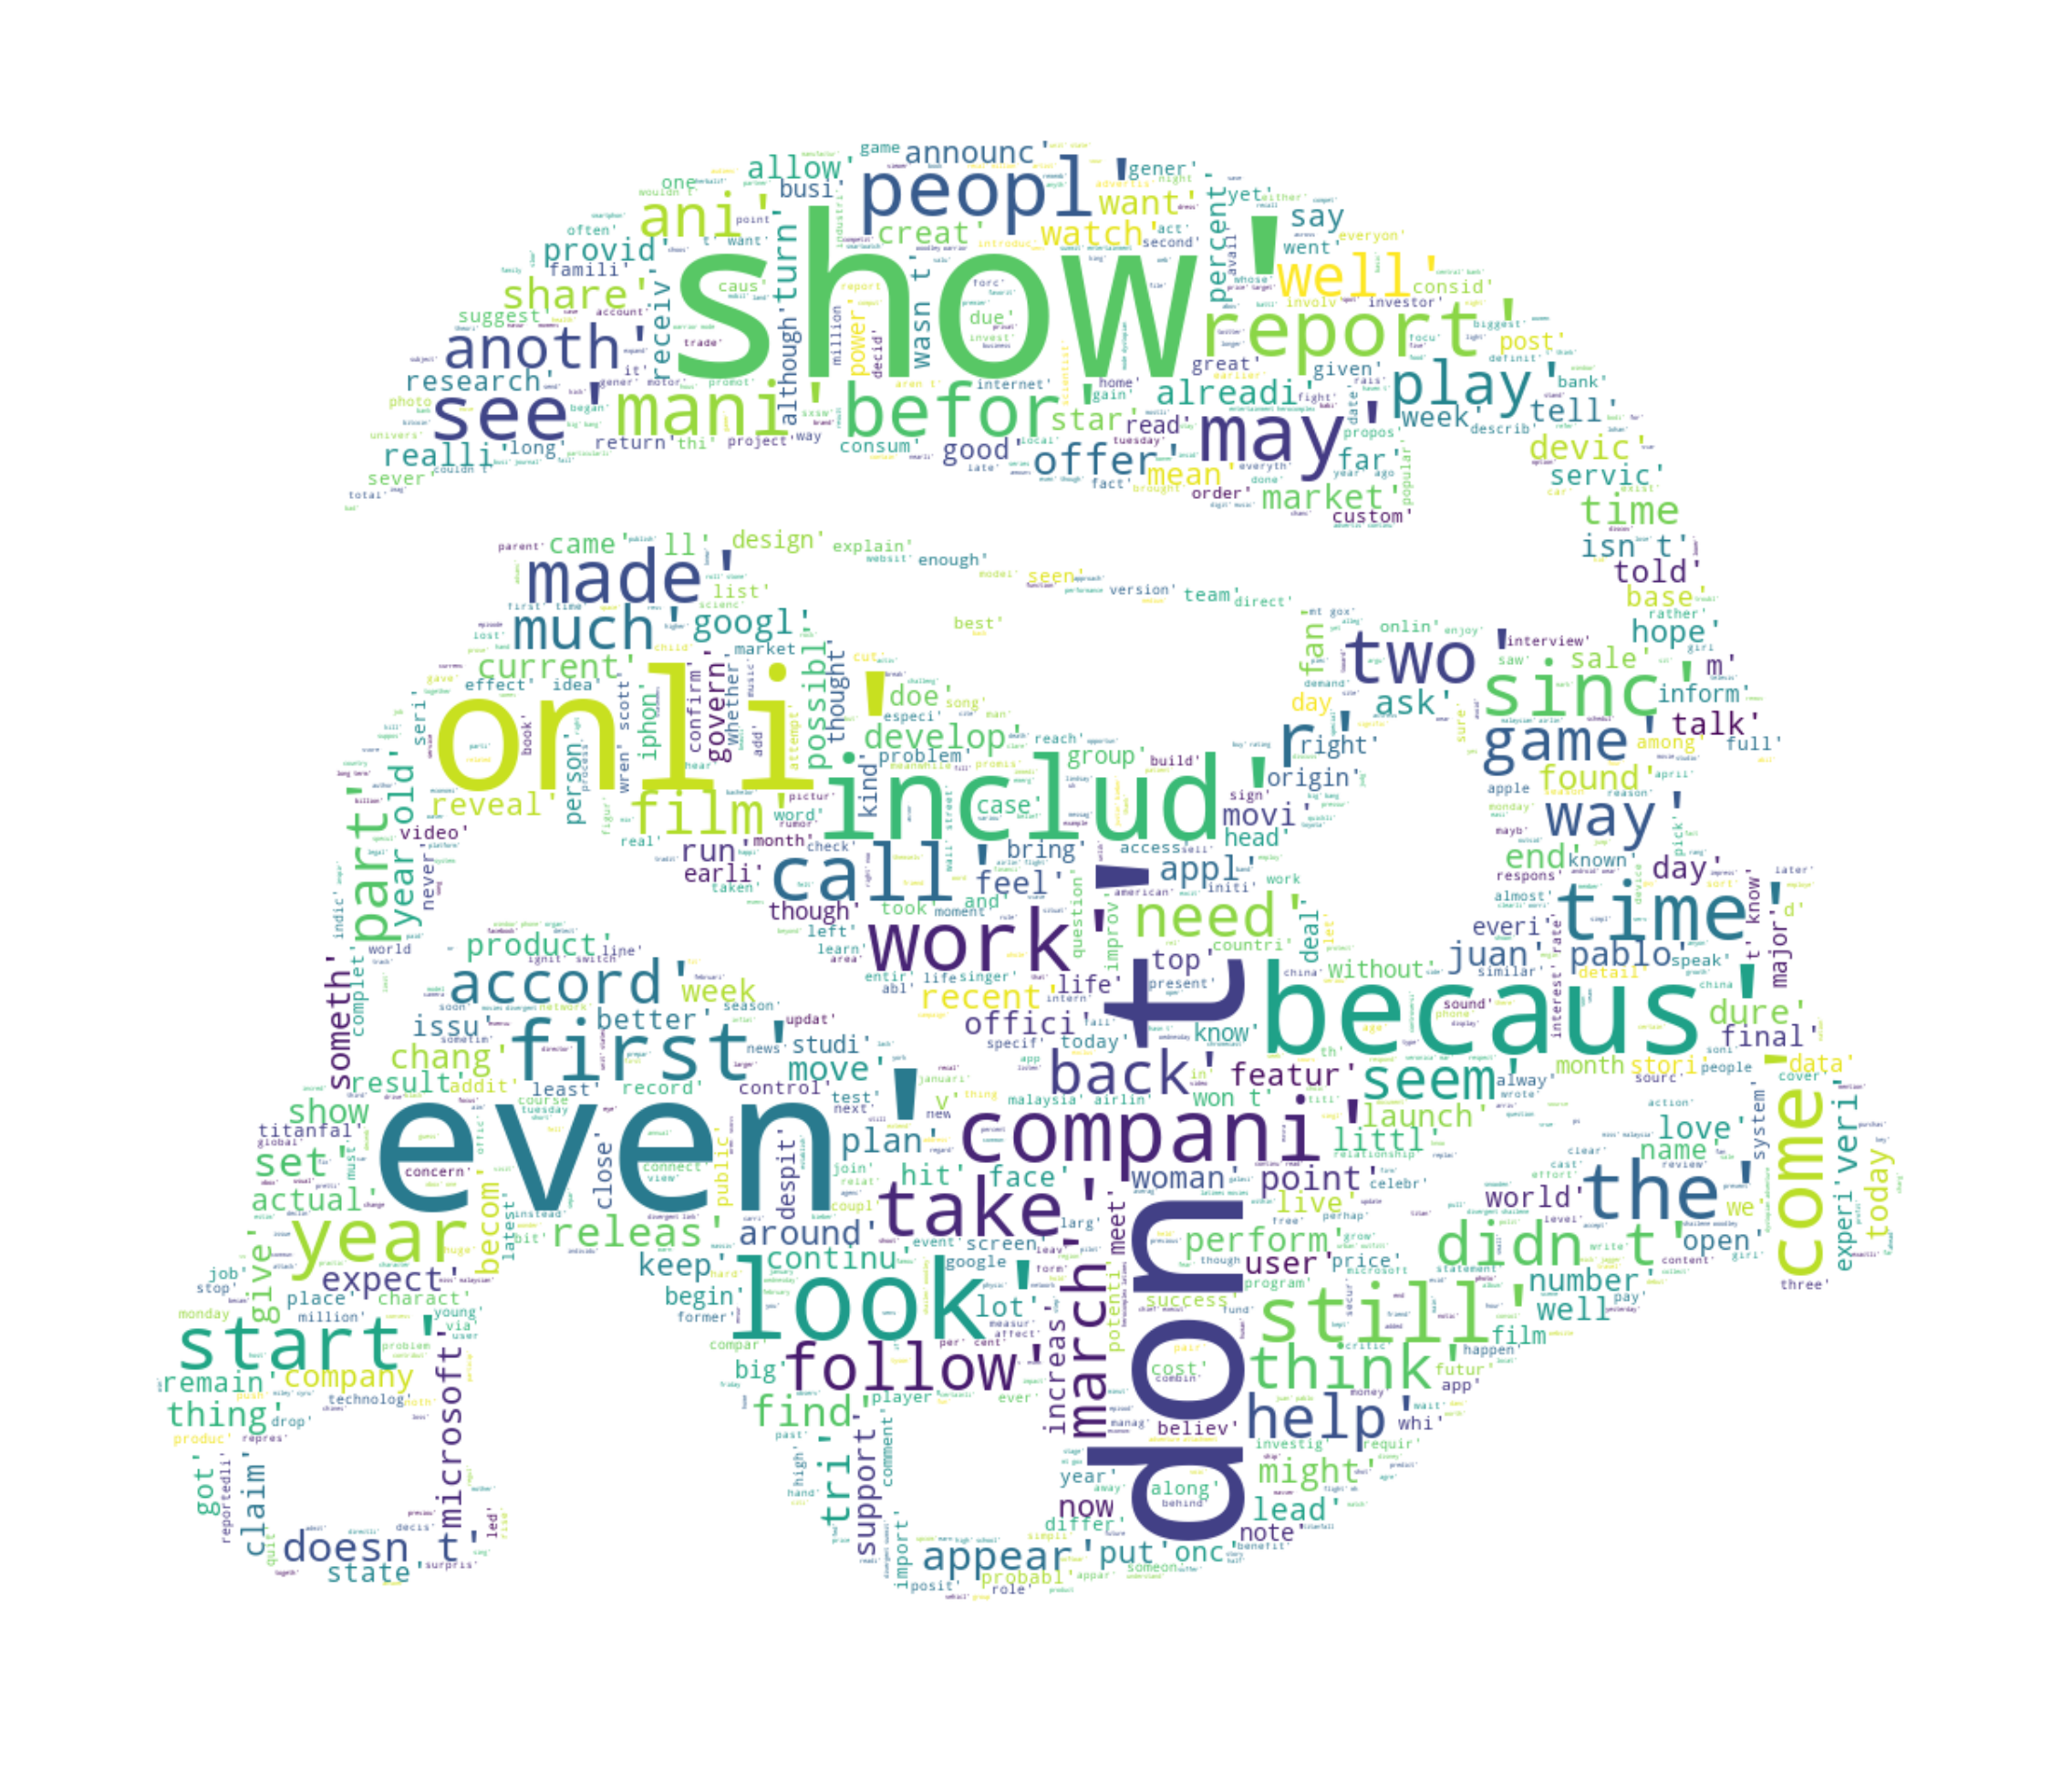

In [18]:
alice_mask = np.array(Image.open("stormtrooper_mask.png"))

wc = WordCloud(background_color="white", max_words=1000, mask=alice_mask)

# generate word cloud
wc.generate(str(cleaned_data_title))

# store to file
wc.to_file("wordcloud_content.png")

# show
plt.figure(figsize=(40,40))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()

### Categorize the Content column into positive, negative, and neutral text. <a id="chapter-10"></a>

In [19]:
bloblist_desc_content = list()

df_review_str_content=df['Content'].astype(str)
for row in df_review_str_content:
    blob_content = TextBlob(row)
    bloblist_desc_content.append((row,blob_content.sentiment.polarity, blob_content.sentiment.subjectivity))
    df_polarity_desc_content = pd.DataFrame(bloblist_desc_content, columns = ['Content','sentiment','polarity'])
 
def f(df_polarity_desc_content):
    if df_polarity_desc_content['sentiment'] > 0:
        val = "Positive Content"
    elif df_polarity_desc_content['sentiment'] == 0:
        val = "Neutral Content"
    else:
        val = "Negative Content"
    return val

df_polarity_desc_content['Sentiment_Type'] = df_polarity_desc_content.apply(f, axis=1)
df_polarity_desc_content.head()

Content  sentiment  polarity  \
0  Paris/London/Atlanta: Federal Reserve Bank of ...   0.082318  0.371394   
1  FRANKFURT, March 10 (Reuters) - The European C...   0.048656  0.353184   
2  The euro retreated from highs unseen since Oct...   0.065611  0.382534   
3  PARIS--The slow pace of price increases and no...   0.028859  0.460753   
4  Fundamental Forecast for Euro: Neutral\r\n\r\n...   0.042328  0.451755   

     Sentiment_Type  
0  Positive Content  
1  Positive Content  
2  Positive Content  
3  Positive Content  
4  Positive Content

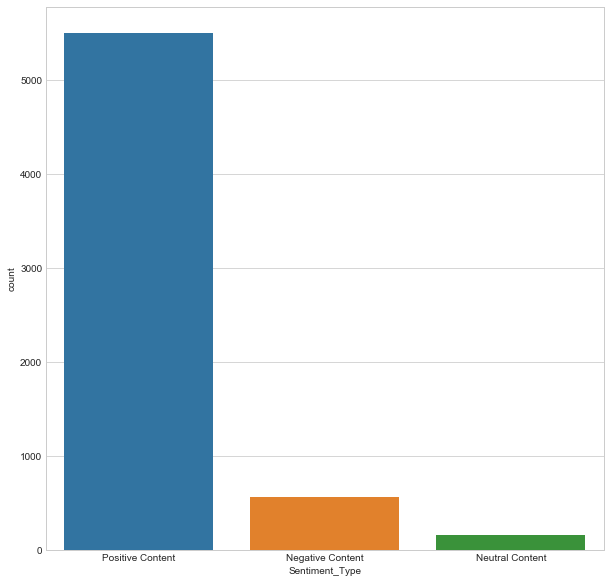

In [20]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc_content)

The above barplot shows that there are more positive content in the dataset

### Vectorization<a id="chapter-11"></a>
> Need each news as some structure that can be fed to learning algorithm. We need to take the raw text and convert it into a vector. 
>> Process -
>> * Sentence Segmentation
>> * Tokenization
>> * Lemmatization
>> * Removing Stop Words
>> * Vectorization

In [21]:
def text_process(title):
    nopunc=[word for word in title if word not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [22]:
# Category column could be transformed to numerical column
category_dummies=pd.get_dummies(df['Category'])
df_polarity_desc=pd.concat((df_polarity_desc,category_dummies),axis=1)


title_class = df_polarity_desc[(df_polarity_desc['Sentiment_Type'] == 'Positive Title') | (df_polarity_desc['Sentiment_Type'] == 'Negative Title')]
X_title=title_class['TITLE']
title_class['Sentiment_Type'] = title_class.Sentiment_Type.map({'Positive Title':1, 'Negative Title':0})
y=title_class['Sentiment_Type']

C:\Users\Ankur\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
bow_transformer=CountVectorizer(analyzer=text_process).fit(X_title)

In [24]:
print(len(bow_transformer.vocabulary_))

6693


In [25]:
X_title = bow_transformer.transform(X_title)

### Training Data and Test Data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_title, y, test_size=0.2, random_state=101)

In [27]:
# Creating Metrics Dataframe
metrics_df = pd.DataFrame(index = ['Metrics_Train','Metrics_Test'])
metrics_df_category= pd.DataFrame(index = ['Metrics_Train','Metrics_Test'])

# Function to print and add metrics to dataframe
def print_metrics(df, model, recall_train, recall_test):
    df[model] = [float("{0:.5f}".format(recall_train)), float("{0:.5f}".format(recall_test))]
    return df

def print_metrics_news_category(df, model, recall_train, recall_test):
    df[model] = [float("{0:.5f}".format(recall_train)), float("{0:.5f}".format(recall_test))]
    return df

### Prediction of News Title<a id="chapter-12"></a>

#### Naive Bayes Model

In [28]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

predict_train = nb.predict(X_train)
predict_test = nb.predict(X_test)

recall_train_nb=f1_score(y_train, predict_train)
recall_test_nb=f1_score(y_test, predict_test)

Once we predicted the values, now the most important task is to check and evaluate our model against the actual sentiment (stored in y_test) using confusion_matrix and classification_report from Scikit-learn.

#### Confusion Matrix

In [29]:
cm = confusion_matrix(y_test, predict_test).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

TN  FP  FN   TP
0  131  64  47  317

In [30]:
# Printing the training and testing metrices

metrics_df = print_metrics(metrics_df, 'Naive Bayes_Model', recall_train_nb, recall_test_nb)
metrics_df

Naive Bayes_Model
Metrics_Train            0.97316
Metrics_Test             0.85101

#### Multi Layer Perceptron

In [31]:
# Import Multi-Layer Perceptron Classifier Model
mlp = MLPClassifier(hidden_layer_sizes=(37,37,37))
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

recall_train_mlp=f1_score(y_train, predict_train)
recall_test_mlp=f1_score(y_test, predict_test)

#### Confusion Matrix

In [32]:
cm = confusion_matrix(y_test, predict_test).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

TN  FP  FN   TP
0  121  74  34  330

In [33]:
# Printing the training and testing metrices

metrics_df = print_metrics(metrics_df, 'MLP_Model', recall_train_mlp, recall_test_mlp)
metrics_df

Naive Bayes_Model  MLP_Model
Metrics_Train            0.97316    1.00000
Metrics_Test             0.85101    0.85938

#### XGBoost

In [34]:
xgb=XGBClassifier()

xgb_fit=xgb.fit(X_train, y_train)

predict_train = xgb.predict(X_train)
predict_test = xgb.predict(X_test)

recall_train_xgb = f1_score(y_train, predict_train)
recall_test_xgb = f1_score(y_test, predict_test)

C:\Users\Ankur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ankur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
cm = confusion_matrix(y_test, predict_test).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

TN   FP  FN   TP
0  57  138   8  356

In [36]:
# Printing the training and testing metrices

metrics_df = print_metrics(metrics_df, 'XGB_Model', recall_train_xgb, recall_test_xgb)
metrics_df

Naive Bayes_Model  MLP_Model  XGB_Model
Metrics_Train            0.97316    1.00000    0.86847
Metrics_Test             0.85101    0.85938    0.82984

From the above accuracy metrics, it is very clear that the Naive Bayes and MLP models are overfitted. Our best model for news sentiment prediction is XG Boost. Since, there is no much difference between training and testing data accuracy of XGB model. But in the other cases, the training accuracy is very high and testing is very low, therefore these models will not give best results on the unseen data. 

In [37]:
pickle_models=pd.DataFrame(columns=['Model Name','Model'])
pickle_models=pickle_models.append({'Model Name':'Naive Bayes', 'Model': nb}, ignore_index=True)
pickle_models=pickle_models.append({'Model Name':'Multi Layer Perceptron', 'Model': mlp}, ignore_index=True)
pickle_models=pickle_models.append({'Model Name':'XG Boost', 'Model': xgb}, ignore_index=True)

### Validation of the model for Title column<a id="chapter-13"></a>

In [38]:
title_positive=df['TITLE'][0]
title_positive

"Fed's Charles Plosser sees high bar for change in pace of tapering"

First, I want to test with the positive title. I have chosen the above title and its sentiment is Positive. After evaluating it should predict the sentiment as Positive.

In [39]:
title_positive_transformed = bow_transformer.transform([title_positive])
nb.predict(title_positive_transformed)[0]

1

Second, I want to test with the negative title. I have chosen the below title and its sentiment is negative. After evaluating it should predict the sentiment as Negative.

In [40]:
title_negative=df['TITLE'][14]
title_negative

"$5 20-piece chicken nuggets didn't help McDonald's reverse US sales decline"

In [41]:
title_negative_transformed = bow_transformer.transform([title_negative])
nb.predict(title_negative_transformed)[0]

0

### Prediction of News Category<a id="chapter-14"></a>

We are predicting whether news is in Business category or Entertainment category

In [42]:
df_news_business_entertainment=df_polarity_desc[(df_polarity_desc['Business']==1) | (df_polarity_desc['Entertainment']==1)]

In [43]:
df_news_business_entertainment.head()

TITLE  sentiment  polarity  \
0  Fed's Charles Plosser sees high bar for change...       0.16      0.54   
1  ECB FOCUS-Stronger euro drowns out ECB's messa...       0.00      0.30   
2  Forex Market: EUR/USD retreats from 2-1/2-year...       0.00      0.00   
3   ECB's Noyer: Low inflation may hamper adjustment       0.00      0.30   
4  ECB Unlocks Door for Further Euro Strength - W...       0.00      0.50   

   Sentiment_Type  Business  Entertainment  Health  Science And Technology  
0  Positive Title         1              0       0                       0  
1   Neutral Title         1              0       0                       0  
2   Neutral Title         1              0       0                       0  
3   Neutral Title         1              0       0                       0  
4   Neutral Title         1              0       0                       0

In [44]:
X_category=df_news_business_entertainment['TITLE']
y=df_news_business_entertainment['Business']

In [45]:
bow_transformer_category=CountVectorizer(analyzer=text_process).fit(X_category)

In [46]:
print(len(bow_transformer_category.vocabulary_))

8024


In [47]:
X_category = bow_transformer_category.transform(X_category)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_category, y, test_size=0.1, random_state=101)

#### Naive Bayes Model

In [49]:
nb.fit(X_train, y_train)

predict_train = nb.predict(X_train)
predict_test = nb.predict(X_test)

recall_train_nb=f1_score(y_train, predict_train)
recall_test_nb=f1_score(y_test, predict_test)

#### Confusion Matrix

In [50]:
cm = confusion_matrix(y_test, predict_test).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

TN  FP  FN   TP
0  183  25  29  160

In [51]:
# Printing the training and testing metrices

metrics_df_category = print_metrics_news_category(metrics_df_category, 'Naive Bayes_Model', recall_train_mlp, recall_test_mlp)
metrics_df_category

Naive Bayes_Model
Metrics_Train            1.00000
Metrics_Test             0.85938

#### XG Boost

In [52]:
xgb_fit=xgb.fit(X_train, y_train)

predict_train = xgb.predict(X_train)
predict_test = xgb.predict(X_test)

recall_train_xgb = f1_score(y_train, predict_train)
recall_test_xgb = f1_score(y_test, predict_test)

C:\Users\Ankur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ankur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Confusion Matrix

In [53]:
cm = confusion_matrix(y_test, predict_test).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

TN  FP   FN  TP
0  201   7  107  82

In [54]:
# Printing the training and testing metrices

metrics_df_category = print_metrics_news_category(metrics_df_category, 'XGB_Model', recall_train_xgb, recall_test_xgb)
metrics_df_category

Naive Bayes_Model  XGB_Model
Metrics_Train            1.00000    0.65365
Metrics_Test             0.85938    0.58993

#### Multi Layer Perceptron

In [55]:
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

recall_train_mlp=f1_score(y_train, predict_train)
recall_test_mlp=f1_score(y_test, predict_test)

#### Confusion Matrix

In [56]:
cm = confusion_matrix(y_test, predict_test).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

TN  FP  FN   TP
0  183  25  28  161

In [57]:
# Printing the training and testing metrices

metrics_df_category = print_metrics_news_category(metrics_df_category, 'MLP_Model', recall_train_mlp, recall_test_mlp)
metrics_df_category

Naive Bayes_Model  XGB_Model  MLP_Model
Metrics_Train            1.00000    0.65365    0.99848
Metrics_Test             0.85938    0.58993    0.85867

From the above accuracy metrics, it is very clear that the Naive Bayes and MLP models are overfitted. Our best model for news category prediction is XG Boost. Since, there is no much difference between training and testing data accuracy of XGB model. But in the other cases, the training accuracy is very high and testing is very low, therefore these models will not give best results on the unseen data.

### Validation of the model News Category<a id="chapter-15"></a>

The below News Title comes under Business News Category. If the output gives 1 then it is predicted successfully.

In [58]:
Category_business=df_news_business_entertainment['TITLE'][0]
Category_business

"Fed's Charles Plosser sees high bar for change in pace of tapering"

In [59]:
Category_business_transformed = bow_transformer_category.transform([Category_business])
nb.predict(Category_business_transformed)[0]

1

The below News Title comes under Entertainment News Category. If the output gives 0 then it is predicted successfully.

In [60]:
category_entertainment=df_news_business_entertainment['TITLE'][6242]
category_entertainment

"REPORT: Older women far more likely to get Alzheimer's than breast cancer"

In [61]:
category_entertainment_transformed = bow_transformer_category.transform([category_entertainment])
nb.predict(category_entertainment_transformed)[0]

0

Our model successfully predicted the news title and category. For this dataset, our best model is XG Boost. The other model has high accuracy in training data but they are overfitting the models.

### Pickle <a id="chapter-16"></a>
> Pickle is the standard way of serializing objects in Python. We can use the pickle operation to serialize our machine learning algorithms and save the serialized format to a file. Later we can load this file to deserialize your model and use it to make new predictions.

In [62]:
# save the model to disk
filename = 'finalized_model_big_data.pkl'
pickle.dump(pickle_models, open(filename, 'wb'))

### MIT License <a id="chapter-17"></a>

Copyright 2018 Ankur Jain, Amandeep Singh, Eklavya Saxena

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.

### References <a id="chapter-18"></a>

1.	http://newspaper.readthedocs.io/en/latest/
2.	https://www.geeksforgeeks.org/newspaper-article-scraping-curation-python/
3.	https://www.smallsurething.com/web-scraping-article-extraction-and-sentiment-analysiswith-scrapy-goose-and-textblob/
4.	https://github.com/nikbearbrown
5.	http://newspaper.readthedocs.io/en/latest/
http://textblob.readthedocs.io/en/dev/quickstart.html
